**Actividad 1 - Sistemas Multiagentes**

Carlos G. del Rosal - A01566719 - 08/11/2021

**Instrucciones**

Dado:

* Habitación de MxN espacios.
* Número de agentes.
* Porcentaje de celdas inicialmente sucias.
* Tiempo máximo de ejecución.

Realiza la siguiente simulación:
* Inicializa las celdas sucias (ubicaciones aleatorias).
* Todos los agentes empiezan en la celda [1,1].

En cada paso de tiempo:
* Si la celda está sucia, entonces aspira.
* Si la celda está limpia, el agente elije una dirección aleatoria para moverse (unas de las 8 celdas vecinas) y elije la acción de movimiento (si no puede moverse allí, permanecerá en la misma celda).

Se ejecuta el tiempo máximo establecido.

Deberás recopilar la siguiente información durante la ejecución:

* Tiempo necesario hasta que todas las celdas estén limpias (o se haya llegado al tiempo máximo).
* Porcentaje de celdas limpias después del termino de la simulación.
* Número de movimientos realizados por todos los agentes.


In [11]:
# !pip install mesa

# Paquete esencial que ayuda a modelar sistemas multiagentes
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import SimultaneousActivation
from mesa.datacollection import DataCollector

# Paquete matemático utilizado para matrices de declaración sencilla
import numpy as np

# Paquetes útiles para trabajar y graficar la animación de la simulación
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128
import pandas as pd

# Nativos de Python para medir tiempos y sus diferencias
import datetime
import time

# Nativo de Python para aleatorizar la posición de las celdas sucias
import random

In [12]:
class Cell(Agent):
  # Constructor
  def __init__(self, id, model, state):
    super().__init__(id, model)

    # Estado actual de la celda. {0: Limpia, 1: Sucia}
    self.state = state
    self.next_state = None
    self.pos = id

In [13]:
# Clase agente del robot que limpia
class CleaningRobot(Agent):
  # Constructor
  def __init__(self, id, model):
    super().__init__(id, model)
    self.pos = id
    self.next_pos = None
  
  # Paso que se programa y ejecuta como un momento de interacción
  def step(self):
    # Primera elección de paso - Limpiar la celda actual
    agents_here = self.model.grid.get_cell_list_contents(self.pos)
    for agent in agents_here:
      if isinstance(agent, Cell):
        if agent.state == 1:
          agent.next_state = 0
          self.next_pos = self.pos
          return
    
    # Segunda elección de paso - Movimiento a una celda vecina
    neighboring_positions = self.model.grid.get_neighborhood(
        self.pos, moore=True, include_center=False
        )
    self.next_pos = random.choice(neighboring_positions)
  
  # Actualización del estado tras la acción seleccionada, lo realizado en step()
  def advance(self):
    agents_here = self.model.grid.get_cell_list_contents(self.pos)
    for agent in agents_here:
      if isinstance(agent, Cell):
        if agent.next_state == 0:
          agent.state = 0
          agent.next_state = 1
    self.model.grid.move_agent(self, self.next_pos)
    self.pos = self.next_pos

In [14]:
# Función auxiliar para capturar el modelo en un momento como datos
def get_grid(model):
  grid = np.zeros((model.grid.width, model.grid.height))
  for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    # Grid almacena 2 si hay robots, 1 si está sucio, 0 si está limpio
    if len(cell_content) > 1:
      grid[x][y] = 2
    else:
      grid[x][y] = cell_content[0].state
  return grid


class CleaningModel(Model):
  # Constructor
  def __init__(self, M, N, NUM_AGENTS, DIRTY_PCT):
    # Inicialización de atributos para almacenar los datos recibidos
    self.M = M
    self.N = N
    self.NUM_AGENTS = NUM_AGENTS
    self.DIRTY_PCT = DIRTY_PCT
    
    # Creacíon de un Multigrid() para poder tener más de un agente por celda
    self.grid = MultiGrid(M, N, False)

    # Permite activar al mismo tiempo todos los componentes del modelo
    self.schedule = SimultaneousActivation(self)

    # Selección aleatoria de las celdas sucias
    dirty_cells = set(random.sample(range(self.M * self.N),
      int(self.M * self.N * self.DIRTY_PCT)))
    
    # Llenado de la cuadrilla con celdas sucias y limpias
    for (content, x, y) in self.grid.coord_iter():
      state = 1 if x * N + y in dirty_cells else 0
      new_cell = Cell((x, y), self, state)
      self.grid.place_agent(new_cell, (x, y))
      self.schedule.add(new_cell)

    # Creación en (0, 0) de los NUM_AGENTS agentes de limpieza
    for id in range(NUM_AGENTS):
      new_robot = CleaningRobot(id, self)
      self.grid.place_agent(new_robot, (0, 0))
      self.schedule.add(new_robot)
    
    # Recolector de datos para futura representación gráfica
    self.datacollector = DataCollector(model_reporters={"Grid": get_grid})

  # Unidad de cambio del modelo. También se llama a actuar a los agentes
  def step(self):
    self.datacollector.collect(self)
    self.schedule.step()
  
  def cleaned(self):
    # Devuelve que no se ha limpiado el tablero al encontrar una celda sucia
    for agent in self.schedule.agents:
      if isinstance(agent, Cell):
        if agent.state == 1:
          return False
    return True

In [15]:
# Parámetros de ejecución
M = 10
N = 10
NUM_AGENTS = 8
DIRTY_PCT = 0.7
MAX_DURATION = 10.0

# Creación del modelo personalizado con MESA
model = CleaningModel(M, N, NUM_AGENTS, DIRTY_PCT)

# Se ejecuta hasta acabar la tarea o alcanzar la duracíon máxima
start_time = time.time()
iterations = 0
while time.time() - start_time < MAX_DURATION and not(model.cleaned()):
  model.step()
  iterations += 1

# Formateo y restricción a un valor máximo del tiempo de ejecución
true_duration = datetime.timedelta(seconds = (time.time() - start_time))
if (true_duration.seconds >= MAX_DURATION):
  print("Duración total: {}s (Máxima)".format(MAX_DURATION))
else:
  print("Duración total: {} (Limpieza terminada a tiempo)".format(
      str(true_duration).split(":")[-1] + "s"
  ))

Duración total: 00.044708s (Limpieza terminada a tiempo)


In [16]:
# Recopila los datos del recolector por ser animados
all_grids = model.datacollector.get_model_vars_dataframe()

In [17]:
# Genera una animación con los datos anteriores
%%capture

# Modificación del mapa de colores para representación más bonita
old_cmap = matplotlib.cm.get_cmap('viridis', 256)
old_colors = old_cmap(np.linspace(0, 1, 256))
old_colors[0] = np.array([256/256, 256/256, 256/256, 1])
old_colors[1:255] = np.array([101/256, 67/256, 33/256, 1])
old_colors[255] = np.array([243/256, 114/256, 32/256, 1])
new_cmap = matplotlib.colors.ListedColormap(old_colors)


fig, axs = plt.subplots(figsize=(7,7))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grids.iloc[0][0], cmap=new_cmap)

def animate(i):
    patch.set_data(all_grids.iloc[i][0])
    
cleaning_simulation = animation.FuncAnimation(fig, animate, frames=iterations)


In [18]:
# Corre la animación generada
cleaning_simulation

In [20]:
# Código que ejecuta múltiples simulaciones con parámetros cambiantes
NUM_SIMULATIONS = 200

# Se considera un tablero de tamaño constante
Mn = 10
Nn = 10

# Restricciones para mantener controladas las simulaciones
AGENT_MAX = 0.8
AGENT_MIN = 0.05
DIRTY_MAX = 0.8
DIRTY_MIN = 0.05
MAX_DURATION = 10.0

# Listas para almacenar y luego graficar los resultados
agents_created = list()
dirty_pct_given = list()
durations_measured = list()
iterations_taken = list()

for i in range(NUM_SIMULATIONS):
  # Parámetros de ejecución
  NUM_AGENTSn = random.randint(int(Mn * Nn * AGENT_MIN), int(Mn * Nn * AGENT_MAX))
  DIRTY_NUMn = random.randint(int(Mn * Nn * DIRTY_MIN), int(Mn * Nn * DIRTY_MAX))
  DIRTY_PCTn = DIRTY_NUMn / (Mn * Nn)

  # Creación del modelo personalizado con MESA
  model = CleaningModel(M, N, NUM_AGENTS, DIRTY_PCT)

  # Se ejecuta hasta acabar la tarea o alcanzar la duracíon máxima
  start_time = time.time()
  iterations = 0
  while time.time() - start_time < MAX_DURATION and not(model.cleaned()):
    model.step()
    iterations += 1
  # Restricción a un valor máximo del tiempo de ejecución
  true_duration = datetime.timedelta(seconds = (time.time() - start_time))
  result_duration = min(MAX_DURATION, float(str(true_duration).split(":")[-1]))
  
  # Almacenamiento de resultados
  agents_created.append(NUM_AGENTSn)
  dirty_pct_given.append(DIRTY_PCTn)
  durations_measured.append(result_duration)
  iterations_taken.append(iterations)

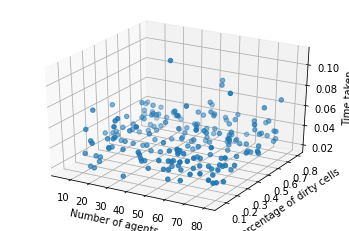

In [21]:
# Segmento de código para comparar tres variables de las pruebas
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(agents_created, dirty_pct_given, durations_measured)

ax.set_xlabel('Number of agents')
ax.set_ylabel('Percentage of dirty cells')
ax.set_zlabel('Time taken')

plt.show()

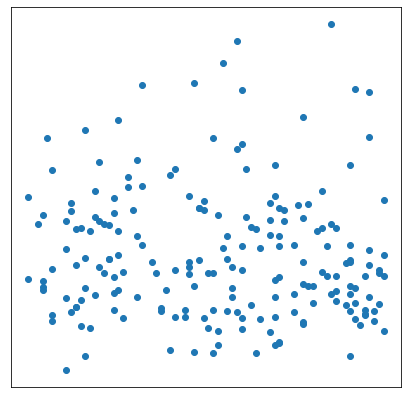

In [22]:
# Segmento de código para graficar y comparar solo dos variables
fig, axs = plt.subplots(figsize=(7,7))
axs.set_xticks([])
axs.set_yticks([])
axs.scatter(agents_created, iterations_taken)